In [1]:
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et 

# VEST GA '18


## Load in Files

### VEST File

In [2]:
vest_ga_18 = gp.read_file("./raw-from-source/VEST/ga_2018/ga_2018.shp")

### VEST Data Documentation

Election results from the Georgia Secretary of State Elections Division  
- https://sos.ga.gov/index.php/Elections/current_and_past_elections_results  

Precinct shapefile primarily from the Georgia General Assembly Reapportionment Office  
- http://www.legis.ga.gov/Joint/reapportionment/en-US/default.aspx

### Precinct Shapefile

In [3]:
precinct_shapes_ga = gp.read_file("./raw-from-source/GA_shapefile/vtd2018-shapefile/VTD2018-Shapefile.shp")

### Election Results (General) 

In [4]:
loaded_counties = os.listdir("./raw-from-source/General_Results/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/General_Results/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        #county = county_area.attrib.get('text')
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
                        #print(x)
                    #print("")
                #print("")
            #print("")
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
df = pd.DataFrame(z,columns=dfcols)
df["num_votes"]=df["num_votes"].astype(int)
office_list = ['Governor', 'Lieutenant Governor', 'Secretary Of State','Attorney General', 'Commissioner Of Agriculture','Commissioner Of Insurance','State School Superintendent','Commissioner Of Labor','Public Service Commission, District 3 - Metro-Atlanta','Public Service Commission, District 5 - Western']
df = df[df["contest"].isin(office_list)]
df["precinct"]=df["precinct"].str.upper()

#### Confirm that totals match VEST

In [5]:
vest_list = ['G18GOVRKEM', 'G18GOVDABR','G18GOVLMET', 'G18LTGRDUN', 'G18LTGDAMI', 'G18SOSRRAF', 'G18SOSDBAR','G18SOSLDUV', 'G18ATGRCAR', 'G18ATGDBAI', 'G18AGRRBLA', 'G18AGRDSWA','G18INSRBEC', 'G18INSDLAW', 'G18INSLFOS', 'G18SPIRWOO', 'G18SPIDTHO','G18LABRBUT', 'G18LABDKEA', 'G18PSCREAT', 'G18PSCDMIL', 'G18PSCLGRA','G18PSCRPRI', 'G18PSCDRAN', 'G18PSCLTUR']
total = 0
for i in vest_list:
    total += sum(vest_ga_18[i])
print(total-sum(df["num_votes"]))

0


#### FIPS Dictionary

In [6]:
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Georgia"]
fips_file["FIPS County"] = fips_file["FIPS County"].astype(str)
fips_file["FIPS County"] = fips_file["FIPS County"].str.zfill(3)
fips_file["County Name"] = fips_file["County Name"].replace("De Kalb","DeKalb")
fips_dict = dict(zip(fips_file['County Name'], fips_file['FIPS County']))


#### Clean and pivot results

In [7]:
df['county_fips'] = df['county'].map(fips_dict).fillna(df['county'])
df['county_fips'] = df['county_fips'].astype(str)
df['county_fips'] = df['county_fips'].str.zfill(3)
df["unique_ID"]=df["county_fips"]+df["precinct"]
df=pd.pivot_table(df,index=["unique_ID","county","county_fips","precinct"],columns=["choice"],values=['num_votes'],aggfunc=sum)
df = df.fillna(0)
df.columns = df.columns.droplevel(0)
df = df.reset_index()
df["TED METZ (LIB)"]+=df["T. METZ (L)"]
df = df.drop(["T. METZ (L)"], axis=1)
df = df.rename(columns={'BRAD RAFFENSPERGER  (REP)':"G18SOSRRAF",'BRIAN KEMP  (REP)':"G18GOVRKEM",'CHARLIE BAILEY  (DEM)': "G18ATGDBAI",'CHRIS CARR (I) (REP)':"G18ATGRCAR",'CHUCK EATON (I) (REP)':"G18PSCREAT",'DAWN A. RANDOLPH (DEM)':"G18PSCDRAN",'DONNIE FOSTER (LIB)':"G18INSLFOS",'FRED SWANN  (DEM)':"G18AGRDSWA",'GARY BLACK (I) (REP)':"G18AGRRBLA",'GEOFF DUNCAN  (REP)':"G18LTGRDUN",'JANICE LAWS  (DEM)':"G18INSDLAW",'JIM BECK  (REP)':"G18INSRBEC",'JOHN BARROW  (DEM)':"G18SOSDBAR",'JOHN TURPISH (LIB)':"G18PSCLTUR",'LINDY MILLER (DEM)':"G18PSCDMIL",'MARK BUTLER (I) (REP)':"G18LABRBUT",'OTHA E. THORNTON, JR (DEM)':"G18SPIDTHO",'RICHARD KEATLEY (DEM)':"G18LABDKEA",'RICHARD WOODS (I) (REP)':"G18SPIRWOO",'RYAN GRAHAM (LIB)':"G18PSCLGRA",'SARAH RIGGS AMICO (DEM)':"G18LTGDAMI",'SMYTHE DUVAL (LIB)':"G18SOSLDUV",'STACEY ABRAMS  (DEM)':"G18GOVDABR",'TED METZ (LIB)':"G18GOVLMET",'TRICIA PRIDEMORE (I) (REP)':"G18PSCRPRI"})
print(df.head())

choice unique_ID   county county_fips precinct  G18SOSRRAF  G18GOVRKEM  \
0          0011B  Appling         001       1B       614.0       701.0   
1          0011C  Appling         001       1C       426.0       498.0   
2           0012  Appling         001        2       359.0       399.0   
3         0013A1  Appling         001      3A1       480.0       519.0   
4          0013C  Appling         001       3C       643.0       727.0   

choice  G18ATGDBAI  G18ATGRCAR  G18PSCREAT  G18PSCDRAN  ...  G18LABRBUT  \
0             93.0       663.0       650.0        88.0  ...       663.0   
1             48.0       466.0       475.0        41.0  ...       484.0   
2            711.0       400.0       397.0       709.0  ...       418.0   
3             23.0       501.0       501.0        26.0  ...       501.0   
4            205.0       694.0       690.0       194.0  ...       710.0   

choice  G18SPIDTHO  G18LABDKEA  G18SPIRWOO  G18PSCLGRA  G18LTGDAMI  \
0             80.0        89.0    

#### Check that totals still match

In [8]:
col_list = ['G18GOVRKEM', 'G18GOVDABR','G18GOVLMET', 'G18LTGRDUN', 'G18LTGDAMI', 'G18SOSRRAF', 'G18SOSDBAR',
       'G18SOSLDUV', 'G18ATGRCAR', 'G18ATGDBAI', 'G18AGRRBLA', 'G18AGRDSWA','G18INSRBEC', 'G18INSDLAW', 'G18INSLFOS', 'G18SPIRWOO', 'G18SPIDTHO',
       'G18LABRBUT', 'G18LABDKEA', 'G18PSCREAT', 'G18PSCDMIL', 'G18PSCLGRA','G18PSCRPRI', 'G18PSCDRAN', 'G18PSCLTUR']
total = 0
for i in col_list:
    total += sum(df[i])-sum(vest_ga_18[i])
print(total)

0.0


### Election Results (Runoff) 

In [9]:
loaded_counties = os.listdir("./raw-from-source/Runoff_Results/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/Runoff_Results/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        #county = county_area.attrib.get('text')
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
                        #print(x)
                    #print("")
                #print("")
            #print("")
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
df_2 = pd.DataFrame(z,columns=dfcols)
df_2["num_votes"]=df_2["num_votes"].astype(int)
runoff_list = ['Secretary Of State','Public Service Commission, District 3 - Metro-Atlanta']
df_2=df_2[df_2["contest"].isin(runoff_list)]
df_2["precinct"]=df_2["precinct"].str.upper()

#### Confirm that totals match VEST

In [10]:
print(sum(df_2["num_votes"]))

vest_list = ['R18SOSRRAF', 'R18SOSDBAR','R18PSCREAT', 'R18PSCDMIL']
total = 0
for i in vest_list:
    total += sum(vest_ga_18[i])
print(total)

2939724
2939724


In [11]:
df_2['county_fips'] = df_2['county'].map(fips_dict).fillna(df_2['county'])
df_2['county_fips'] = df_2['county_fips'].astype(str)
df_2['county_fips'] = df_2['county_fips'].str.zfill(3)
df_2["unique_ID"] = df_2["county_fips"] + df_2["precinct"]
df_2 = pd.pivot_table(df_2,index=["unique_ID","county","county_fips","precinct"],columns=["choice"],values=['num_votes'],aggfunc=sum)
df_2 = df_2.fillna(0)
df_2.columns = df_2.columns.droplevel(0)
df_2 = df_2.reset_index()
df_2 = df_2.rename(columns={'BRAD RAFFENSPERGER  (REP)':"R18SOSRRAF",'CHUCK EATON (I) (REP)':"R18PSCREAT",'JOHN BARROW  (DEM)': "R18SOSDBAR",'LINDY MILLER (DEM)':"R18PSCDMIL"})
print(df_2.head())

choice unique_ID   county county_fips precinct  R18SOSRRAF  R18PSCREAT  \
0          0011B  Appling         001       1B         292         291   
1          0011C  Appling         001       1C         194         208   
2           0012  Appling         001        2         150         156   
3         0013A1  Appling         001      3A1         206         213   
4          0013C  Appling         001       3C         290         295   

choice  R18SOSDBAR  R18PSCDMIL  
0               40          35  
1               25           9  
2              304         289  
3               25          17  
4               91          82  


In [12]:
#Check that totals still match
vest_list = ['R18SOSRRAF', 'R18SOSDBAR','R18PSCREAT', 'R18PSCDMIL']
total = 0
total_2 = 0
for i in vest_list:
    total += sum(df_2[i])
    total_2 += sum(vest_ga_18[i])
print(total)
print(total_2)

2939724
2939724


## Merge Election Results and Shapefiles

In [13]:
#Check the shapes
print(df.shape)
print(df_2.shape)

#Change to from "185CLYATT"
df.loc[2003,"unique_ID"]="185CLYATTVILLE"
df_2 = df_2[['unique_ID','R18SOSRRAF','R18PSCREAT', 'R18SOSDBAR', 'R18PSCDMIL']]
ga_election=pd.merge(df,df_2,on='unique_ID',how='outer',indicator=True)

(2634, 29)
(2634, 8)


In [14]:
print(ga_election["_merge"].value_counts())
ga_election = ga_election.drop(["_merge"],axis=1)

both          2634
right_only       0
left_only        0
Name: _merge, dtype: int64


In [15]:
#Create a unique ID column
precinct_shapes_ga["FIPS2"] = precinct_shapes_ga["FIPS2"].astype(str)
precinct_shapes_ga["FIPS2"] = precinct_shapes_ga["FIPS2"].str.zfill(3)
precinct_shapes_ga["unique_ID"] =precinct_shapes_ga["FIPS2"]+precinct_shapes_ga["PRECINCT_N"]
precinct_shapes_ga["unique_ID"] = precinct_shapes_ga.apply(lambda x: (x['DISTRICT']) if (pd.isna(x["unique_ID"])) else x["unique_ID"], axis=1)

## Process and Merge the Shapefiles and Election Results


## VEST Processing (from documentation):

**1. COMPLETED**  
Fulton County uses shapefiles and maps sourced from the county GIS program. Precincts CH01/CH04B, CP07A/CP07D, SS29A/SS29B, UC031/UC035 were merged to match how voters were registered in the 2018 voter file. 
- Files needed: Fulton County GIS files  

**2. COMPLETED**  
The following precincts were split by congressional district to match the 2018 election results: Avondale High, Glennwood, Wadsworth in Dekalb County; Cates D in Gwinnett County.   
- Files needed: 2018 congressional map   

**3. PARTIALLY COMPLETED (see below)**  
Cloudland and Teloga precincts in Chattooga County were split along the ridgeline that marks the boundary between them with the USGS Topographic Contour shapefile.
- Files needed: USGS Topographic Contour shapefile      

**4. COMPLETED**   
Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only has one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.
- Files needed: n/a**  
- *Note: For whatever reason, this already seems to have been done on the files*

### Instruction 1

In [16]:
#Remove the Fulton precincts from the shapefile
precinct_shapes_ga = precinct_shapes_ga[~(precinct_shapes_ga["DISTRICT"].str[0:3]=="121")]

#Import the Fulton precincts
fulton_precincts = gp.read_file("./raw-from-source/Fulton_2018/Precincts2018.shp")

#Create a unique ID for the Fulton precincts
fulton_precincts['PRECINCT_N'] = fulton_precincts["VoterDist"]
fulton_precincts=fulton_precincts[['PRECINCT_N',"geometry"]]
fulton_precincts["unique_ID"]="121"+fulton_precincts['PRECINCT_N']
fulton_precincts.to_crs(precinct_shapes_ga.crs,inplace=True)

#Add columns to make append work
fulton_precincts['DISTRICT']=fulton_precincts["unique_ID"]
fulton_precincts['CTYSOSID']=fulton_precincts["unique_ID"]
fulton_precincts['PRECINCT_I']=fulton_precincts['PRECINCT_N']
fulton_precincts['CTYNAME']="Fulton"
fulton_precincts['CTYNUMBER']="60"
fulton_precincts['COUNTY']="060"
fulton_precincts['FIPS2']="121"

precinct_crs = precinct_shapes_ga.crs
precinct_shapes_ga = precinct_shapes_ga.append(fulton_precincts)
precinct_shapes_ga = gp.GeoDataFrame(precinct_shapes_ga, crs=precinct_crs)

In [17]:
#Merge precinct CH04B into CH01
prec2combine = [precinct_shapes_ga.loc[precinct_shapes_ga["unique_ID"]=="121CH01"],precinct_shapes_ga.loc[precinct_shapes_ga["unique_ID"]=="121CH04B"]]
val = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = precinct_crs).unary_union
precinct_shapes_ga.loc[precinct_shapes_ga["unique_ID"]=="121CH01","geometry"] = gp.GeoDataFrame(geometry=[val]).geometry.values
precinct_shapes_ga = precinct_shapes_ga[precinct_shapes_ga["unique_ID"]!="121CH04B"]

In [18]:
#Merge precinct CP07A into CP07D
prec2combine = [precinct_shapes_ga.loc[precinct_shapes_ga["unique_ID"]=="121CP07A"],precinct_shapes_ga.loc[precinct_shapes_ga["unique_ID"]=="121CP07D"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = precinct_crs)
precinct_shapes_ga.loc[precinct_shapes_ga["unique_ID"]=="121CP07D","geometry"]=new_fort.unary_union
precinct_shapes_ga = precinct_shapes_ga[precinct_shapes_ga["unique_ID"]!="121CP07A"]

In [19]:
#Merge precinct SS29B into SS29A
prec2combine = [precinct_shapes_ga.loc[precinct_shapes_ga["unique_ID"]=="121SS29A"],precinct_shapes_ga.loc[precinct_shapes_ga["unique_ID"]=="121SS29B"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = precinct_crs)
precinct_shapes_ga.loc[precinct_shapes_ga["unique_ID"]=="121SS29A","geometry"]=new_fort.unary_union
precinct_shapes_ga = precinct_shapes_ga[precinct_shapes_ga["unique_ID"]!="121SS29B"]

In [20]:
#Merge precinct UC035 into UC031
prec2combine = [precinct_shapes_ga.loc[precinct_shapes_ga["unique_ID"]=="121UC031"],precinct_shapes_ga.loc[precinct_shapes_ga["unique_ID"]=="121UC035"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = precinct_crs)
precinct_shapes_ga.loc[precinct_shapes_ga["unique_ID"]=="121UC031","geometry"]=new_fort.unary_union
precinct_shapes_ga = precinct_shapes_ga[precinct_shapes_ga["unique_ID"]!="121UC035"]

### Instruction 2

#### Import Congressional File and grab needed GA districts

In [21]:
#Upload the districts and filter down to just Georgia
us_congress = gp.read_file("./raw-from-source/Congressional_Districts/tl_2018_us_cd116/tl_2018_us_cd116.shp")
ga_congress = us_congress[us_congress["STATEFP"]=="13"]

#Grab the needed districts for these splits
district_4 = ga_congress.loc[[91]]
district_5 = ga_congress.loc[[92]]
district_7 = ga_congress.loc[[98]]
district_4["geometry"]=district_4.buffer(0)
district_5["geometry"]=district_5.buffer(0)
district_7["geometry"]=district_7.buffer(0)
district_4.to_crs(precinct_shapes_ga.crs,inplace=True)
district_5.to_crs(precinct_shapes_ga.crs,inplace=True)
district_7.to_crs(precinct_shapes_ga.crs,inplace=True)

#### 1. Avondale

In [22]:
#Locate the avondale precinct and its index
avondale_high = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="AVONDALE HIGH"]

#Calculate the intersection
avondale_high_4 = gp.overlay(district_4,avondale_high, how='intersection',keep_geom_type=False)
avondale_high_5 = gp.overlay(district_5,avondale_high, how='intersection',keep_geom_type=False)

#Filter down columns
avondale_high_4 = avondale_high_4[['ID', 'AREA', 'DATA', 'DISTRICT', 'CTYSOSID','PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME','FIPS2', 'geometry', 'unique_ID']]
avondale_high_5 = avondale_high_5[['ID', 'AREA', 'DATA', 'DISTRICT', 'CTYSOSID','PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME','FIPS2', 'geometry', 'unique_ID']]

#Rename the "county_prec"
avondale_high_4['unique_ID']="089AVONDALE HIGH - 04"
avondale_high_5['unique_ID']="089AVONDALE HIGH - 05"

#Add the new files to the dataframe
precinct_shapes_ga = precinct_shapes_ga.append(avondale_high_4)
precinct_shapes_ga = precinct_shapes_ga.append(avondale_high_5)
precinct_shapes_ga.reset_index(drop=True, inplace=True)

#Drop the old precinct
precinct_shapes_ga = precinct_shapes_ga[~(precinct_shapes_ga["unique_ID"]=="089AVONDALE HIGH")]

#### 2. Glennwood

In [23]:
#Locate the glennwood precinct and its index
glennwood = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="GLENNWOOD (DEC)"]

#Calculate the intersection
glennwood_4 = gp.overlay(district_4,glennwood, how='intersection',keep_geom_type=False)
glennwood_5 = gp.overlay(district_5,glennwood, how='intersection',keep_geom_type=False)

#Filter down columns
glennwood_4 = glennwood_4[['ID', 'AREA', 'DATA', 'DISTRICT', 'CTYSOSID','PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME','FIPS2', 'geometry', 'unique_ID']]
glennwood_5 = glennwood_5[['ID', 'AREA', 'DATA', 'DISTRICT', 'CTYSOSID','PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME','FIPS2', 'geometry', 'unique_ID']]

#Rename the "county_prec"
glennwood_4['unique_ID']="089GLENNWOOD - 04"
glennwood_5['unique_ID']="089GLENNWOOD - 05"

#Add the new files to the dataframe
precinct_shapes_ga = precinct_shapes_ga.append(glennwood_4)
precinct_shapes_ga = precinct_shapes_ga.append(glennwood_5)
precinct_shapes_ga.reset_index(drop=True, inplace=True)

#Drop the old precinct
precinct_shapes_ga = precinct_shapes_ga[~(precinct_shapes_ga["unique_ID"]=="089GLENNWOOD (DEC)")]

#### 3. Wadsworth

In [24]:
#Locate the wadsworth precinct and its index
wadsworth = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="WADSWORTH"]

#Calculate the intersection
wadsworth_4 = gp.overlay(district_4,wadsworth, how='intersection',keep_geom_type=False)
wadsworth_5 = gp.overlay(district_5,wadsworth, how='intersection',keep_geom_type=False)

#Filter down columns
wadsworth_4 = wadsworth_4[['ID', 'AREA', 'DATA', 'DISTRICT', 'CTYSOSID','PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME','FIPS2', 'geometry', 'unique_ID']]
wadsworth_5 = wadsworth_5[['ID', 'AREA', 'DATA', 'DISTRICT', 'CTYSOSID','PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME','FIPS2', 'geometry', 'unique_ID']]
 
#Rename the "county_prec"
wadsworth_4['unique_ID']="089WADSWORTH - 04"
wadsworth_5['unique_ID']="089WADSWORTH - 05"

#Add the new files to the dataframe
precinct_shapes_ga = precinct_shapes_ga.append(wadsworth_4)
precinct_shapes_ga = precinct_shapes_ga.append(wadsworth_5)
precinct_shapes_ga.reset_index(drop=True, inplace=True)

#Drop the old precinct
precinct_shapes_ga = precinct_shapes_ga[~(precinct_shapes_ga["unique_ID"]=="089WADSWORTH")]

#### 4. Cates

In [25]:
#Locate the Cates precinct and its index
cates_d = precinct_shapes_ga[precinct_shapes_ga["PRECINCT_N"]=="CATES D"]

#Calculate the intersection
cates_d_4 = gp.overlay(district_4,cates_d, how='intersection',keep_geom_type=False)
cates_d_7 = gp.overlay(district_7,cates_d, how='intersection',keep_geom_type=False)

#Filter down columns
cates_d_4 = cates_d_4[['ID', 'AREA', 'DATA', 'DISTRICT', 'CTYSOSID','PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME','FIPS2', 'geometry', 'unique_ID']]
cates_d_7 = cates_d_7[['ID', 'AREA', 'DATA', 'DISTRICT', 'CTYSOSID','PRECINCT_I', 'PRECINCT_N', 'CTYNUMBER', 'COUNTY', 'CTYNAME','FIPS2', 'geometry', 'unique_ID']]

#Rename the "county_prec"
cates_d_4['unique_ID']="135CATESD"
cates_d_7['unique_ID']="135035 Cates D - 04"

#Add the new files to the dataframe
precinct_shapes_ga = precinct_shapes_ga.append(cates_d_4)
precinct_shapes_ga = precinct_shapes_ga.append(cates_d_7)
precinct_shapes_ga.reset_index(drop=True, inplace=True)

#Drop the old precinct
precinct_shapes_ga = precinct_shapes_ga[~(precinct_shapes_ga["unique_ID"]=="135CATES D")]

### Instruction 3:

This instruction involved splitting the Cloudland Teloga precinct on a certain ridgeline. Loading VEST's final file as well as the precinct shapefile into a GIS sofware gave us confirmation that they indeed split the precinct on the ridgeline. 

(34.493477, 34.589756)

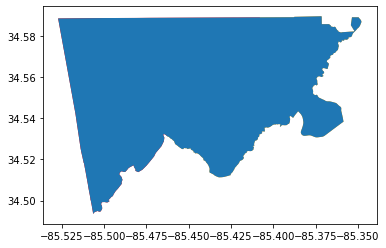

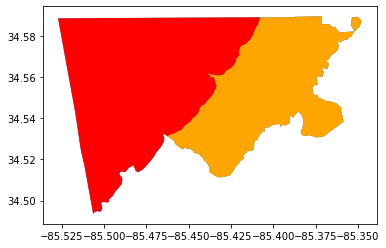

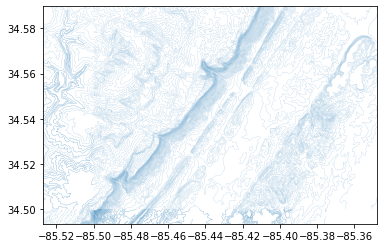

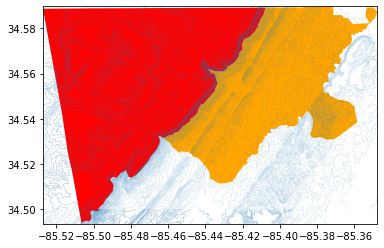

In [26]:
#Printing with the merged precinct on top
ax2 = precinct_shapes_ga[precinct_shapes_ga["CTYSOSID"]=="055XC-96"].plot(zorder=2)
vest_ga_18[vest_ga_18["PRECINCT_N"]=="CLOUDLAND"].plot(ax=ax2,color="red")
vest_ga_18[vest_ga_18["PRECINCT_N"]=="TELOGA"].plot(ax=ax2,color="orange")

#Printing with the split precincts on top
ax = precinct_shapes_ga[precinct_shapes_ga["CTYSOSID"]=="055XC-96"].plot()
vest_ga_18[vest_ga_18["PRECINCT_N"]=="CLOUDLAND"].plot(ax=ax,color="red")
vest_ga_18[vest_ga_18["PRECINCT_N"]=="TELOGA"].plot(ax=ax,color="orange")

#Import the topo lines
elev_contour_1 = gp.read_file("./raw-from-source/Topographic_Lines/VECTOR_Dougherty_Gap_GA_7_5_Min_Shape/Elev_Contour.shp")
elev_contour_2 = gp.read_file("./raw-from-source/Topographic_Lines/VECTOR_Jamestown_AL_7_5_Min_Shape/Elev_Contour.shp")

#Plot the elev_countours
ax3 = elev_contour_1.plot(linewidth=0.1)
elev_contour_2.plot(ax=ax3,linewidth=0.1)
minx, miny, maxx, maxy = precinct_shapes_ga[precinct_shapes_ga["CTYSOSID"]=="055XC-96"].total_bounds
ax3.set_xlim(minx, maxx)
ax3.set_ylim(miny, maxy)

#Confirm that the precincts are really split on a ridgeline
ax4 = vest_ga_18[vest_ga_18["PRECINCT_N"]=="CLOUDLAND"].plot(color="red")
vest_ga_18[vest_ga_18["PRECINCT_N"]=="TELOGA"].plot(ax=ax4,color="orange")
elev_contour_1.plot(ax=ax4,linewidth=0.1)
elev_contour_2.plot(ax=ax4,linewidth=0.1)
minx, miny, maxx, maxy = precinct_shapes_ga[precinct_shapes_ga["CTYSOSID"]=="055XC-96"].total_bounds
ax4.set_xlim(minx, maxx)
ax4.set_ylim(miny, maxy)

#As you can see the precinct is not plotted exactly on 

In [27]:
#Merge the election results to check those
data_columns = ['G18SOSRRAF','G18GOVRKEM', 'G18ATGDBAI', 'G18ATGRCAR', 'G18PSCREAT', 'G18PSCDRAN','G18INSLFOS', 'G18AGRDSWA', 'G18AGRRBLA', 'G18LTGRDUN', 'G18INSDLAW','G18INSRBEC', 'G18SOSDBAR', 'G18PSCLTUR', 'G18PSCDMIL', 'G18LABRBUT',
       'G18SPIDTHO', 'G18LABDKEA', 'G18SPIRWOO', 'G18PSCLGRA', 'G18LTGDAMI','G18SOSLDUV', 'G18GOVDABR', 'G18GOVLMET', 'G18PSCRPRI',  'R18SOSRRAF', 'R18PSCREAT', 'R18SOSDBAR','R18PSCDMIL']

for i in data_columns:
        ga_election.loc[ga_election["unique_ID"]=="055CLOUDLAND",i]=int(ga_election.loc[ga_election["unique_ID"]=="055CLOUDLAND",i])+int(ga_election.loc[ga_election["unique_ID"]=="055TELOGA",i])

ga_election.loc[ga_election['precinct']=="CLOUDLAND",'unique_ID']="055CLOULDLAND-TELOGA"       
ga_election = ga_election[ga_election["unique_ID"]!="055TELOGA"]

### Instruction 4:

In [28]:
index_fort_1 = precinct_shapes_ga[precinct_shapes_ga["DISTRICT"]=="053FTBEN1"].index.values[0]
index_fort_2 = precinct_shapes_ga[precinct_shapes_ga["DISTRICT"]=="053FTBEN2"].index.values[0]
index_fort_3 = precinct_shapes_ga[precinct_shapes_ga["DISTRICT"]=="053FTBEN3"].index.values[0]

prec2combine = [precinct_shapes_ga.loc[precinct_shapes_ga["unique_ID"]=="053ACTIVITY CENTER"],precinct_shapes_ga[precinct_shapes_ga["DISTRICT"]=="053FTBEN1"],precinct_shapes_ga[precinct_shapes_ga["DISTRICT"]=="053FTBEN2"],precinct_shapes_ga[precinct_shapes_ga["DISTRICT"]=="053FTBEN3"]]

new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = precinct_crs)
precinct_shapes_ga.loc[precinct_shapes_ga["unique_ID"]=="053ACTIVITY CENTER","geometry"]=new_fort.unary_union
precinct_shapes_ga.loc[precinct_shapes_ga["unique_ID"]=="053ACTIVITY CENTER","unique_ID"]="053ACTIVITY CENTER (Includes FTBEN 1-3)"


precinct_shapes_ga = precinct_shapes_ga.drop([index_fort_1,index_fort_2,index_fort_3])
precinct_shapes_ga.reset_index(drop=True, inplace=True)

#### Make Changes to Names to Increase Match Rates

In [29]:
changes_dict = {'321SYLVER EAST': '321SYLVESTER EAST', '317SENIOR CITIZEN CENTER': '317SENIOR CITIZEN CENTE', '317METASVILLE FIRE STATION': '317METASVILLE FIRE STA', '315ROCHELLE SOUTH 4': '315ROCHELLE SOUTH #4', '315ROCHELLE NORTH 1': '315ROCHELLE NORTH #1', '315PITTS 3': '315PITTS #3', '315PINEVIEW 2': '315PINEVIEW #2', '315ABBEVILLE SOUTH 5': '315ABBEVILLE SOUTH #5', '315ABBEVILLE NORTH 2': '315ABBEVILLE NORTH #2', '311MT. YONAH': '311MT YONAH', '295LAFAYETTE': '295LA FAYETTE', '279514 S.T.I.A.L.C': '279514 S.T.I.A.L.C.', '27939 NEW BRANCH': '27939 NEWBRANCH', '277MOTT-LITTMAN GYM': '277MOTT-LITMAN GYM', '275MERRILLVILLE': '275MERRILVILLE', '275FIRE STATION 2': '275FIRE STATION #2', '269#6 REYNOLDS': '269PRECINCT 6', '269#5 COURTHOUSE': '269PRECINCT 5', '269#1 BUTLER FIRE DEPT.': '269PRECINCT 1', '251SCREVEN REC DEPT': '251SCREVEN REC. DEPT.', '247STANTON': '247ST', '247ST. PIUS': '247SP', '247SMYRNA': '247SM', '247ROCKDALE': '247RO', '247OLDE TOWNE': '247OT', '247MILSTEAD': '247MI', '247MAGNET': '247MA', '247LORRAINE': '247LO', '247THE LAKES': '247LA', '247HIGHTOWER': '247HI', '247HONEY CREEK': '247HC', '247FLAT SHOALS': '247FS', '247FIELDSTONE': '247FI', '247CONYERS': '247CO', '247BETHEL': '247BT', '247BARKSDALE': '247BA', '241RABUN': '241RABUN COUNTY', '215ST PETER U. M. C.': '215ST. PETER', '215ST. MARK/HEIFERHORN': '215ST MARK/HEIFERHORN', '215ST. ANDREWS/MIDLAND': '215ST ANDREWS/MIDLAND', '215MT. PILGRIM': '215MT PILGRIM', '215CORNERSTONE CHURCH': '215CORNERSTONE', '215BRITT DAVID BAPT CH': '215BRITT DAVID', '211WEST MORGAN': '2116. WEST MORGAN', '211NORTHEAST MORGAN': '2111. NORTHEAST MORGAN', '211NORTH MORGAN': '2117. NORTH MORGAN', '211EAST MORGAN': '2112. EAST MORGAN', '211CLACKS CHAPEL': '2115. CLACKS CHAPEL', '211CENTRAL MORGAN': '2114. CENTRAL MORGAN', '211BETH/SPRINGFIELD': '2113. BETH/SPRINGFIELD', '199WOODBURY': '199LOWER 9TH-WOODBURY', '199WARM SPRINGS': '1992ND-WARM SPRINGS', '199ODESSADALE': '1997TH-ODESSADALE', '199MANCHESTER GILL II': '199GILL II', '199MANCHESTER GILL I': '199GILL I', '199GREENVILLE': '1998TH-GREENVILLE', '199GAY': '199MIDDLE 9TH-GAY', '199DURAND': '199THIRD-DURAND', '199ALVATON': '199UPPER 9TH -ALVATON', '197FT. PERRY': '197FORT PERRY', '193MONTEZUMA 5': '193MONTEZUMA #5', '193MONTEZUMA 4': '193MONTEZUMA #4', '177SOVEREIGN GRACE': '177#8 SOVEREIGN GRACE', '177SMITHVILLE': '177#2 SMITHVILLE', '177SDA CHURCH': '177#7 SDA CHURCH', '177REDBONE': '177#10 REDBONE', '177LEESBURG': '177#4 LEESBURG', '177FRIENDSHIP BAPT': '177#5 FRIENDSHIP BAPT.', '177FIRST BAPTIST': '177#6 FIRST BAPTIST', '177CJC': '177#3 CJC', '177CHOKEE': '177#1 CHOKEE', '177CENTURY FIRE STATION': '177#9 CENTURY FIRE STAT', '175LCFS 10 (VALAMBROSIA)': '175LCFS #10 (VALAMBROSIA)', '175FAMILY LIFE CENTER': '175FBC - FLC', '161HAZELHURST': '161HAZLEHURST', '151MT. CARMEL': '151MOUNT CARMEL', '13931-FRIENDSHIP IV': '139FRIENDSHIP IV', '13930-FRIENDSHIP III': '139FRIENDSHIP III', '13929-FRIENDSHIP II': '139FRIENDSHIP II', '13928-FRIENDSHIP I': '139FRIENDSHIP I', '13927-BIG HICKORY': '139BIG HICKORY', '13926-GILLSVILLE': '139GILLSVILLE', '13925-GAINESVILLE V': '139GAINESVILLE V', '13924-GAINESVILLE IV': '139GAINESVILLE IV', '13923-GAINESVILLE III': '139GAINESVILLE III', '13922-GAINESVILLE II': '139GAINESVILLE II', '13921-GAINESVILLE I': '139GAINESVILLE I', '13920-WEST WHELCHEL': '139WEST WHELCHEL', '13919-WHELCHEL': '139WHELCHEL', '13918-FORK': '139FORK', '13917-CHESTATEE': '139CHESTATEE', '13916-BARK CAMP': '139BARK CAMP', '13915-QUILLIANS': '139QUILLIANS', '13914-CLERMONT': '139CLERMONT', '13913-LULA': '139LULA', '13912-GLADE': '139GLADE', '13911-TADMORE': '139TADMORE', '13910-CANDLER': '139CANDLER', '13909-MORGAN II': '139MORGAN II', '13908-MORGAN I': '139MORGAN I', '13907-ROBERTS': '139ROBERTS', '13906-FLOWERY BRANCH II': '139FLOWERY BRANCH II', '13905-FLOWERY BRANCH I': '139FLOWERY BRANCH I', '13904-OAKWOOD II': '139OAKWOOD II', '13903-OAKWOOD I': '139OAKWOOD I', '13902-CHICOPEE': '139CHICOPEE', '13901-WILSON': '139WILSON', '131CAIRO 5TH DISTRICT': '131CAIRO 5TH DISTR', '131CAIRO 4TH DISTRICT': '131CAIRO 4TH DISTR', '127STERLING ELEM SCHOOL': '127STERLING ELEMENTARY', '127STERLING CHURCH OF GOD': '127STERLING CH. OF GOD', '127BURROUGHS': '127BURROUGHS MOLETTE', '127BALLARD COMPLEX': '127BALLARD COMMUNITY BUILDING', '097FIRST BAPTIST CHURCH': '097FIRST BAPTIST DOUGLASVILLE', '097FIRST BAPTIST - LITHIA SPRINGS': '097FIRST BAPTIST LITHIA SPRINGS', '097BEULAH': '097BEULAH BAPTIST CHURCH', '095SHILOH BAPTIST CHURCH': '095SHILOH BAPTIST CHURC', '095SECOND MT. ZION': '0952ND MT ZION CHURCH', '095PUTNEY 1ST BAPT CHURCH': '095PUTNEY 1ST BAPT CHUR', '095PINE BLUFF BAPT CHURCH': '095PINE BLUFF BAPT CHUR', '095PALMYRA RD METH CHURCH': '095PALMYRA METH CHURCH', '095MT. ZION CENTER': '095MT ZION CENTER', '095LAMAR REESE ELEM SCHOOL': '095LAMAR REESE ELEM SCH', '095FIRST CHRISTIAN CHURCH': '0951ST CHRISTIAN CHURCH', '095COVENANT PRES CHURCH': '095COVENANT CHURCH', '091YONKER': '091YONKE', '091VILULA': '091VILUL', '091RAWLINS': '091RAWLI', '091PONDTOWN': '091PONDT', '091PLAINFIELD': '091PLAIN', '091MULLIS': '091MULLI', '091MITCHELL': '091MITCH', '091MCCRANIE': '091MCCRA', '091JAYBIRD': '091JAYBI', '091EMPIRE': '091EMPIR', '091CHAUNCEY': '091CHAUN', '089WINTERS CHAPEL': '089WINTERS CHAPEL (DUN)', '089TILLY MILL ROAD': '089TILLY MILL ROAD (DUN)', '089TERRY MILL ELEM': '089TERRY MILL', '089STONE MOUNTAIN MIDDLE': '089STN MTN MIDDLE', '089STONE MOUNTAIN CHAMPION': '089STONE MTN CHAMPION (STO)', '089SNAPFINGER ROAD SOUTH': '089SNAPFINGER ROAD S', '089SNAPFINGER ROAD NORTH': '089SNAPFINGER ROAD N', '089SKYLAND': '089SKYLAND (BHAVN)', '089SILVER LAKE': '089SILVER LAKE (BHAVN)', '089RENFROE MIDDLE': '089RENFROE (DEC)', '089PONCE DE LEON': '089PONCE DE LEON (DEC)', '089PINE LAKE': '089PINE LAKE (PIN)', '089PEACHTREE MIDDLE': '089PEACHTREE MIDDLE (DUN)', '089OAKHURST': '089OAKHURST (DEC)', '089NORTH PEACHTREE': '089NORTH PEACHTREE (DUN)', '089MT. VERNON WEST': '089MOUNT VERNON WEST (DUN)', '089MT. VERNON EAST': '089MOUNT VERNON EAST (DUN)', '089MONTGOMERY ELEM': '089MONTGOMERY ELEM  (BHAVN)', '089MILLER-ELDRIDGE L. MILLER ELEM': '089MILLER-ELDRIDGE L MILLER ELEM', '089METROPOLITAN': '089METROPOLITAN (ATL)', '089LITHONIA': '089LITHONIA (LIT)', '089LIN-MARY LIN ELEM': '089LIN-MARY LIN ELEM (ATL)', '089KITTREDGE ELEM': '089KITTREDGE ELEM (BHAVN)', '089KINGSLEY ELEM': '089KINGSLEY ELEM (DUN)', '089JOHNSON ESTATES': '089JOHNSON ESTATES (ATL)', '089IDLEWOOD ELEM': '089IDLEWOOD ELEM (TUC)', '089HUNTLEY HILLS ELEM': '089HUNTLEY HILLS ELEM (CHA)', '089HARRIS-NARVIE J. HARRIS ELEM': '089NARVIE J HARRIS ELEM', '089GEORGETOWN SQUARE': '089GEORGETOWN SQ (DUN)', '089EPWORTH': '089EPWORTH (ATL)', '089DUNWOODY LIBRARY': '089DUNWOODY LIBRARY (DUN)', '089DUNWOODY': '089DUNWOODY (DUN)', '089DRESDEN ELEM': '089DRESDEN ELEM (CHA)', '089DORAVILLE SOUTH': '089DORAVILLE SOUTH (DOR)', '089DORAVILLE NORTH': '089DORAVILLE NORTH (DOR)', '089CROSS KEYS HIGH': '089CROSS KEYS HIGH (BHAVN)', '089CLARKSTON': '089CLARKSTON (CLA)', '089CLAIREMONT WEST': '089CLAIREMONT WEST (DEC)', '089CLAIREMONT EAST': '089CLAIREMONT EAST (DEC)', '089CHESNUT ELEM': '089CHESNUT ELEM (DUN)', '089CHAMBLEE 2': '089CHAMBLEE 2 (CHA)', '089BURGESS ELEM': '089BURGESS ELEM (ATL)', '089BROOKHAVEN': '089BROOKHAVEN (BHAVN)', '089BROCKETT ELEM': '089BROCKETT ELEM (TUC)', '089BROCKETT': '089BROCKETT (TUC)', '089BRIARWOOD': '089BRIARWOOD (BHAVN)', '089BOULEVARD': '089BOULEVARD (ATL)', '089BOULDERCREST RD': '089BOULDERCREST ROAD', '089AVONDALE': '089AVONDALE (AVO)', '089AUSTIN': '089AUSTIN (DUN)', '089ASHFORD PARKSIDE': '089ASHFORD PARKSIDE (BHAVN)', '089ASHFORD PARK ELEM': '089ASHFORD PARK ELEM (BHAVN)', '089ASHFORD DUNWOODY RD': '089ASHFORD DUNWOODY RD (BHAVN)', '087MT PLEASANT': '087MT. PLEASANT', '087BRIDGE-FAIRGROUNDS': '087BDGE-FAIRGROUNDS', '075NEW LIFE BAPT. CHURCH': '075NEW LIFE BAPTIST CH.', '073WOODLAWN BAPTIST CHURCH': '073WOODLAWN BAPT CHURCH', '073MTZ COL FIRE HDQTR': '073MTZ COL FIRE HDQTR.', '073MARVIN METHODIST CHURCH': '073MARVIN METHODIST', '073LEWIS METHODIST CHURCH': '073LEWIS METHODIST', '073GROVETOWN MIDDLE SCHOOL': '073GROVETOWN MIDDLE SCH', '073GROVETOWN METHODIST CHURCH': '073GROVETOWN METHODIST', '073EUBANK/BLANCHARD CENTER': '073EUBANK/BLANCHARD CTR', '073DAMASCUS BAPTIST CHURCH': '073DAMASCUS BAPT CHURCH', '073COL CTY BD OF EDU': '073COL CTY BOARD OF EDU', '073CHRIST THE KING LUTH CH': '073CHRIST THE KING CH', '073CHRIST CHURCH': '073CHRIST CHURCH, PRESBYTERIAN', '073BLUE RIDGE ELEMENTARY': '073BLUERIDGE ELEMENTARY', '067MOUNT BETHEL 04': '067MT BETHEL 04', '067MOUNT BETHEL 03': '067MT BETHEL 03', '067MOUNT BETHEL 01': '067MT BETHEL 01', "061DAY'S CROSS ROADS": '061DAYS CROSS ROAD', '061COURTHOUSE': '061COURT HOUSE', '0518-12 BEACH HIGH SCHOOL': '051BEACH HIGH SCHOOL', '0518-01 CIVIC CENTER': '051CIVIC CENTER', '0517-06 POOLER CITY HALL': '051POOLER CITY HALL', '0516-06 THE LIGHT': '051THE LIGHT CHURCH', '0515-07 ELKS LODGE': '051ELKS LODGE', '0515-06 SEED CHURCH': '051SEED CHURCH', '0514-15 SKIDAWAY ISLAND STATE PARK': '051SKIDAWAY ISLAND STAT', '0514-14 SKIDAWAY ISLAND METHODIST CHURCH': '051SKID METHODIST CH', '0513-10 BIBLE BAPTIST CHURCH': '051BIBLE BAPTIST CHURCH', '0513-08 JENKINS HIGH SCHOOL': '051JENKINS HIGH SCHOOL', '0513-03 SAVANNAH HIGH SCHOOL': '051SAVANNAH HIGH SCHOOL', '0513-02 ROSE OF SHARON': '051ROSE OF SHARON', '0513-01 OLD COURTHOUSE': '051OLD COURTHOUSE', '0512-12 WILLIAMS COURT': '051WILLIAMS COURT APTS', '0512-03 W. W. LAW CENTER': '051W W LAW CENTER', '0511-17 ISLANDS CHRISTIAN CHURCH': '051ISLANDS CHRISTIAN CH', '0511-13 THE SANCTUARY': '051THE SANCTUARY', '0511-01 FIRST PRESBYTERIAN CHURCH': '051FIRST PRESBYTERIAN CHURCH', '047FORT OGLETHORPE': '047FT OGLETHORPE', '045WHITESBURG (682)': '045WHITESBURG', '045WEST CARROLLTON (714A1)': '045WEST CARROLLTON', '045VILLA RICA CITY (642)': '045VILLA RICA CITY', '045V R COUNTY SOUTH (640)': '045V R COUNTY SOUTH', 
                '045V R COUNTY NORTH (641)': '045V R COUNTY NORTH', '045UNIVERSITY OF W. GA (714A4)': '045UNIVERSITY OF W. GA', '045TYUS (1533)': '045TYUS', '045TEMPLE COUNTY (649)': '045TEMPLE COUNTY', '045TEMPLE CITY (650)': '045TEMPLE CITY', '045TABERNACLE CHURCH (714A6)': '045TABERNACLE CHURCH', '045SANDHILL (1122)': '045SANDHILL', '045ROOPVILLE (713)': '045ROOPVILLE', '045OLD CAMP CHURCH (714BW)': '045OLD CAMP CHURCH', '045OAK GROVE (715)': '045OAK GROVE', '045MT ZION (1240)': '045MT ZION', '045KANSAS (1006)': '045KANSAS', '045HULETT (1542)': '045HULETT', '045FAIRFIELD (1540)': '045FAIRFIELD', '045COUNTY ADMIN BLDG (714A5)': '045COUNTY ADMIN BLDG', '045CLEM (1483)': '045CLEM', '045CENTER POINT (1152)': '045CENTER POINT', '045BURWELL (1371)': '045BURWELL', '045BOWDON JUNCTION (1496)': '045BOWDON JUNCTION', '045BOWDON (1111)': '045BOWDON', '045BONNER (714A3)': '045BONNER', '045BETHANY (501)': '045BETHANY', '043METTER -1685': '043METTER - 1685', '043CANDLER-1736': '043CANDLER - 1736', '029J.F. GREGORY PARK': '029J.F.GREGORY PARK', '015WOODLAND HIGH': '015WOODLAND', '01316 THE CHURCH AT WINDER': '013THE CHURCH AT WINDER', '01315 COUNTY LINE ELEMENTARY SCHOOL': '013COUNTY LINE ELEMENTARY SCHOOL', '01314 CEDAR CREEK BAPTIST CHURCH': '013CEDAR CREEK BAPTIST CHURCH', '01313 WINDER COMMUNITY CENTER': '013WINDER COMMUNITY CENTER', '01312 MIDWAY UNITED METHODIST CHURCH': '013MIDWAY UNITED METHODIST CHURCH', '01311 APALACHEE HIGH SCHOOL': '013APALACHEE HIGH SCHOOL', '01310 LEISURE SERVICES CENTER': '013LEISURE SERVICES CENTER', '01309 LIONS CLUB': '013LIONS CLUB', '01307 STATHAM ELEMENTARY SCHOOL': '013STATHAM ELEMENTARY SCHOOL', '01306 WINDER BARROW HIGH SCHOOL': '013WINDER-BARROW HIGH SCHOOL', '01305 FIRE STATION 1 (STATHAM)': '013FIRE STATION 1 (STATHAM)', '01304 WESTSIDE MIDDLE SCHOOL': '013WESTSIDE MIDDLE SCHOOL', '01303 BRAMLETT ELEMENTARY SCHOOL': '013BRAMLETT ELEMENTARY SCHOOL', '01301 BETHLEHEM COMMUNITY CENTER': '013BETHLEHEM COMMUNITY CENTER', '007HOGGARD MILL': '007HOGGARDS MILL', '053CHATTAHOOCHEE ACVITITY CENTER': '053ACTIVITY CENTER (Includes FTBEN 1-3)', '25521 EAGLES LANDING BAPTIST': '25521', '25520 ROBERTS FIRE STATION': '25520', '25519 FIRST ASSEMBLY OF GOD CHURCH': '25519', '25517 AMBUCS PARK GYM': '25517', '25516 GARY REID FIRE STATION': '25516', '25514 SUNNYSIDE METHODI': '25514', '25513 COUNTY LINE METHODIST CHURCH': '25513', '25512 LIBERTY SPRINGS BAPT CHURCH': '25512', '25511 FIRST PRESBYTERIAN CHURCH': '25511', '25510 CARVER FIRE STATION': '25510', '25509 UNION BAPTIST CHURCH': '25509', '25508 ST. JOHN LUTHERAN CHURCH': '25508', '25507 FIRST METHODIST': '25507', '25506 CITY PARK': '25506', '25505 UGA CAMPUS': '25505', '25503 SENIOR CENTER': '25503', '25502 FAIRMONT': '25502', '25501 SECOND BAPTIST CH': '25501', '0598C FIRESTATION #7': '0598C', '0598B CEDAR SHLS HIGH SCH': '0598B', '0598A GAINES SCHOOL': '0598A', '0597C FIRESTATION #3': '0597C', '0597B ATHENS REGIONAL LIBRARY': '0597B', '0597A TIMOTHY BPTST CHURCH': '0597A', '0596D FIRESTATION #4': '0596D', '0596C TIMOTHY RD ELEM SCHL': '0596C', '0596B GEORGIA SQUARE MALL': '0596B', '0596A CLEVELAND RD SCHOOL': '0596A', '0595D ACC FLEET MGT BLDG': '0595D', '0595C CHASE STREET SCHOOL': '0595C', '0595B WHITEHEAD RD SCHOOL': '0595B', '0595A OGLETHORPE SCHOOL': '0595A', '0594B MEMORIAL PARK': '0594B', '0594A ATHENS TRANSIT CTR': '0594A', '0593B THOMAS N. LAY PARK': '0593B', '0593A CLARKE CENTRAL HIGH': '0593A', '0592B HOWARD STROUD SCHOOL': '0592B', '0592A JUDIA J. HARRIS SCH': '0592A', '0591D WHIT DAVIS SCHOOL': '0591D', '0591C BARNETT SHLS SCHOOL': '0591C', '0591B E. ATHENS BAPTIST': '0591B', "0591A W'VILLE TRAIN DEPOT": '0591A','271LUMBER CITY': '271LUMBER-CITY', '261W-27 AG CENTER': '261AG CENTER', '261O-26 PLAINS': '261PLAINS', '261N-26 CONCORD': '261CONCORD', '261E-27 AIRPORT': '261AIRPORT', '261C3-27 REC DEPT': '261REC DEPT', '261C2-27 GSWF CONF CENTER': '261GSW CONF CENTER', '261C1-27 REES PARK': '261REES PARK', '26129 ANDERSONVILLE': '261ANDERSONVILLE', '26128 CHAMBLISS': '261CHAMBLISS', '26117 THOMSON': '261THOMSON', '26115 LESLIE': '261LESLIE', '251COOPERVILLE FIRE STA': "251FOY'S STORE", '243FOUNTAIN BRIDGE-5TH': '243FOUNTAIN BRIDGE', '223SARA RAGSDALE ELM SC': '223SARA RAGSDALE ELEM SCHOOL', '223PAULDING CO HIGH SC': '223PAULDING CO HIGH SCHOOL', '223NEBO ELEMENTARY SCH': '223NEBO ELEM SCHOOL', '223CARL SCOGGINS MID SC': '223CARL SCOGGINS MIDDLE SCHOOL', '215EPWORTH': '215EPWORTH UMC', '189139 - WHITEOAK': '189139', '189137 - MARSHALL CHURCH': '189137', '189136 - THOMSON DEPOT': '189136', '189135 - SWEETWATER': '189135', '189134 - VANDERHORST': '189134', '189133B - DEARING GYM': '189133B', '189133A - FORT CREEK': '189133A', '189132 - AUGUSTA TECH': '189132', '189131 - QUEEN OF ANGELS': '189131', '179WALTHOURVILLE CITY HALL': '179WALTHOURVILLE', '175W T ADAMS FIRESTATION': '175W T ADAMS FIRE STA #18', '165JENKINS CO': '165JENKINS CO PRIM/ELEM', '141MAYFIELD': '141MAYFIELD COMMUNITY CENTER', '141DEVEREUX FIRE': '141DEVEREUX FIRE STATION', '135PINCKNEYVILLE A': '135PINKCNEYVILLE A', '135035 CATES D - 04': '135035 Cates D - 04', '119SOUTHWEST': '119SOUTHWEST FRANKLIN', '119NORTHEAST': '119NORTHEAST FRANKLIN', '097LITHIA HIGH SCHOOL': '097LITHIA SPRINGS HIGH SCHOOL', '089WOODWARD': '089WOODWARD (BHAVN)', '089WINNONA PARK': '089WINNONA PARK  (DEC)', '089STONE MOUNTAIN': '089STONE MTN   (STO)', '089EAST LAKE': '089EAST LAKE (ATL)', '089DUNWOODY 2': '089DUNWOODY 2 (DUN)', '089COVINGTON HIGHWAY': '089COVINGTON HWY', '089COAN RECREATION CENTER': '089COAN RECREATION CENTER (ATL)', '089CHAMBLEE ': '089CHAMBLEE (CHA)', "0795": '079DISTRICT 5', "0794": '079DISTRICT 4', "0793": '079DISTRICT 3', "0792": '079DISTRICT 2', "0791B": '079DISTRICT 1B', '0791A': '079DISTRICT 1A', '073WARREN BAPTIST': '073WARREN BAPTIST CHURCH-GROVETOWN', '073SECOND MT. CARMEL': '073SECOND MT. CARMEL BAPTIST CHURCH', '073LIBERTY PARK': '073LIBERTY PARK - GROVETOWN', '073KIOKEE BAPTIST CHURCH': '073KIOKEE BAPT CHURCH', '073HARLEM BRANCH': '073HARLEM BRANCH LIBRARY', '073BELAIR BAPTIST': '073BELAIR BAPTIST CHURCH', '0518-07 WOODVILLE-TOMPKINS': '051WOODVILLE-TOMPKINS TECHNICAL INST', '0517-05 WOODLAWN BAPT CH': '051WOODLAWN BAPTIST CHURCH', '0516-05 WINDSOR FOREST GOLDE': '051WINDSOR HALL', '0516-02 WINDSOR FOREST BAPTIST': '051WINDSOR FOREST BAPTIST CHURCH SCHOOL', '0514-08 WILMINGTON ISLAND PR': '051WILMINGTON ISLAND PRESBYTERIAN CHURCH', '0514-07 WILM IS UN METH CH': '051WILMINGTON ISLAND UNITED METHODIST CHURCH', '0516-01 WHITE BLUFF PRES CHR': '051WHITE BLUFF PRESBYTERIAN CHURCH', '0518-05 W BROAD ST YMCA': '051WEST BROAD STREET YMCA', '0514-11 TYBEE ISLAND SCHOOL CAFE': '051TYBEE IS SCH CAFE', '0516-09 TRINITY LUTHERAN CH': '051TRINITY LUTHERAN CHURCH', '0518-06 TOMPKINS REC CTR': '051TOMPKINS RECREATION CENTER', '0513-12 THUNDERBOLT MUNI. COMPLEX': '051THUNDERBOLT MUN COMP', '0512-09 THE SALVATION ARMY': '051SALVATION ARMY', '0512-11 STILLWELL TOWERS ': '051STILLWELL TOWERS', '0514-12 ST PETERS EPISCOPAL': '051ST PETERS EPISCOPAL', '0511-14 ST LUKE CHURCH': '051ST LUKE CHURCH', '0514-05 ST FRANCIS EPISCOPAL': '051SAINT FRANCIS EPISCOPAL CHURCH', '0517-13 SOUTHSIDE FIRE': '051SOUTHSIDE FIRE TRAINING CENTER', '0513-11 SOUTHSIDE BAPT CHURCH': '051SOUTHSIDE BAPTIST CH', '0514-13 SKID IS PRES CHURCH': '051SKID IS PRES CHURCH', '0518-03 SILK HOPE BAPT CH': '051SILK HOPE BAPTIST CHURCH', '0517-11 SEVENTH DAY ADV CHR': '051SEVENTH DAY ADV CHR', '0515-02 SENIOR CITIZENS CENT': '051SENIOR CITIZEN CENTER', '0515-08 SAVANNAH PRIMITIVE': '051SAVANNAH PRIMITIVE BAPTIST CHURCH', '0517-09 SAVANNAH HOLY': '051SAVANNAH HOLY CHURCH OF GOD', '0516-08 SAVANNAH COMMONS': '051SAVANNAH COMMONS', '0518-13 SAVANNAH CHRIST. SCH': '051SAVANNAH CHRISTIAN S', '0511-10 SAINT THOMAS EPISCOPAL CHURCH': '051ST. THOMAS EPISCOPAL CHURCH', '0517-07 ROTHWELL BAPT CH': '051ROTHWELL BAPTIST CHURCH', '0517-15 RICE CREEK SCHOOL': '051RICE CREEK SCHOOL', '0518-08 RESUR OF OUR LORD CH': '051RESURRECTION OF OUR LORD CATHOLIC CHURCH', '0517-10 PROGRESSIVE REC CTR': '051PROGRESSIVE REC CTR', '0517-03 P B EDWARDS GYM': '051PB EDWARDS GYMNASIUM', '0513-14 OGLETHORPE': '051OGLETHORPE CHARTER ACADEMY', '0513-13 NEW COV 7 DAY ADV CH': '051NEW COV 7 DAY ADV CH', '0518-09 MOSES JACKSON CTR': '051MOSES JACKSON CENTER', '0514-04 LIGHTHOUSE BAPTIST CH': '051LIGHTHOUSE BAPTIST CHURCH', '0515-05 LIBERTY CITY COMM CTR': '051LIBERTY CITY COMMUNITY CENTER', '0515-11 LARGO-TIBET ELEM': '051LARGO-TIBET ELEMENTA', '0517-04 LAKE SHORE COMM CTR': '051LAKE SHORE COMMUNITY CENTER', '0515-10 JONESVILLE BAPT CHURCH': '051JONESVILLE BAPT CH', '0511-05 JEA BUILDING': '051J E A', '0511-12 ISLE OF HOPE BAPTIST': '051ISLE OF HOPE BAPTIST', '0511-09 IMMANUEL BAPT CHURCH': '051IMMANUEL BAPTIST CHURCH', '0512-05 HOLY SPIRIT LUTHERAN': '051HOLY SPIRIT LUTHERAN CHURCH', '0518-02 HELLENIC CENTER': '051HELLENIC CENTER', '0514-10 GUARD HOUSE COMM CTR': '051GUARD HOUSE COMM CTR', '0511-08 GRACE UNITED METH CHUR': '051GRACE UNITED METHODIST CHURCH', '0516-10 GEORGETOWN ELEM': '051GEORGETOWN ELEMENTAR', '0517-01 GARDEN CITY SENIOR CTR': '051GARDEN CITY SENIOR CENTER', '0518-15 GARDEN CITY REC CTR': '051GARDEN CITY REC CTR', '0514-02 FRANK MURRAY COMM CT': '051FRANK MURRAY COMMUNITY CENTER', '0514-06 FIRST BAPTIST CHURCH': '051FIRST BAPTIST CHURCH OF THE ISLAND', '0513-04 FIRST AFRICAN BAPTIST': '051FIRST AFRICAN BAPTIST CHURCH', '0511-16 FERGUSON AVE BAPTIST': '051FERGUSON AVE BAPTIST', '0512-04 FELLOWSHIP OF LOVE': '051FELLOWSHIP OF LOVE COMMUNITY CHURCH', '0516-03 CRUSADER COMM CTR': '051CRUSADER COMMUNITY CENTER', '0513-09 COKESBURY METHODIST': '051COKESBURY METHODIST CHURCH', '0517-14 COASTAL CATHEDRAL': '051COASTAL CATHEDRAL', '0512-07 CHRIST COMM. CHURCH': '051CHRIST COMMUNITY CHURCH AT MORNINGSIDE', '0511-06 CENTRAL CHUR OF CHRIST': '051CENTRAL CHURCH OF CHRIST', '0518-10 CARVER HEIGHTS COMM': '051CARVER HEIGHTS COMM', '0515-03 BUTLER PRESBYTERIAN': '051BUTLER PRESBYTERIAN CHURCH ED BLDG', '0518-11 BUTLER ELEM SCHOOL': '051BUTLER ELEMENTARY SC', '0517-08 BLOOMINGDALE COM CTR': '051BLOOMINGDALE COMMUNITY CENTER', '0512-02 BLACKSHEAR COMM CTR': '051BLACKSHEAR COMMUNITY CENTER', '0515-01 BARTLETT MIDDLE SCH': '051BARTLETT MIDDLE SCHOOL', '0516-11 BAMBOO FARMS': '051BAMBOO FARMS', '0513-05 ALDERSGATE YOUTH CENT': '051ALDERSGATE YOUTH CENTER', '049FOLKSTON FIRE STATION': '049FOLKSTON FIRE', '045LAKESHORE REC (714A2)': '045LAKESHORE REC CENTER', '045BURSON (714BN)': '045BURSON CENTER', '035BUTTS CO ADMIN BLDG': '035BUTTS COUNTY ADMIN BLDG', '029RH REC COMPLEX': '029RH RECREATION COMPX', '029PUBLIC SAFETY COMPLEX': '029PUBLIC SAFETY COMPX', '023FAIRGROUND': '0231', '01308 FIRST BAPTIST CHURCH': '013FIRST BAPTIST CHURCH  WINDER', '01302 BETHLEHEM CHURCH - 211': '013BETHLEHEM CHURCH - 211 CAMPUS', '009SOUTH MILL': '009SOUTH MILLEDGEVILLE', '009NORTH MILL': '009NORTH MILLEDGEVILLE'
               ,"0512-11 STILLWELL TOWERS":"051STILLWELL TOWERS","0517-12 POOLER CHURCH":"051POOLER CHURCH"
               ,'299MILLWOOD':'299Millwood', 
                '299MANOR':'299Manor',
                 '299WARESBORO':'299Waresboro',
                 '299BEACH-BICKLEY':'299Beach-Bickley',
                 '299HAYWOOD':'299Haywood',
                '299JAMESTOWN':'299Jamestown',
                 '299DISTRICT 2B':'299District 2B',
                 '299DISTRICT 1':'299District 1',
                '299DISTRICT 2A':'299District 2A'}

In [30]:
practice_dict = {"0793": '079DISTRICT 3',"0792":'079DISTRICT 2',"0794":'079DISTRICT 4',"0795":'079DISTRICT 5'}
#ga_election['unique_ID'] = ga_election['unique_ID'].map(practice_dict).fillna(ga_election['unique_ID'])
ga_election.loc[:,'unique_ID']=ga_election.loc[:,'unique_ID'].map(practice_dict).fillna(ga_election.loc[:,'unique_ID'])

In [31]:
ga_election['unique_ID'] = ga_election['unique_ID'].map(changes_dict).fillna(ga_election['unique_ID'])

In [32]:
precinct_shapes_ga.loc[precinct_shapes_ga['CTYSOSID'] == "0513-15C","unique_ID"]= "0513-15 ELI WHITNEY COMPLEX"
precinct_shapes_ga.loc[precinct_shapes_ga['CTYSOSID'] == "0512-06C","unique_ID"]= "0512-06 ELI WHITNEY"

In [33]:
shapefile_changes = {'299408': '299Millwood', 
                     '299304': '2991231-150C',
                     '299407': '299Manor',
                     '299400': '2991231-151',
                     '299409': '299Waresboro',
                     '299404': '299Beach-Bickley',
                     '299405': '299Haywood',
                     '299300': '2991231-150B',
                     '299406': '299Jamestown',
                     '299200B':'299District 2B',
                     '299100': '299District 1',
                     '299200A': '299District 2A',
                     "135CATESD":"135CATES D"}

In [34]:
precinct_shapes_ga['unique_ID'] = precinct_shapes_ga['unique_ID'].map(shapefile_changes).fillna(precinct_shapes_ga['unique_ID'])

In [35]:
vest_empty = vest_ga_18[(vest_ga_18['G18SOSRRAF']==0) & (vest_ga_18['G18GOVRKEM']==0) &
              (vest_ga_18['G18ATGDBAI']==0) & (vest_ga_18['G18ATGRCAR']==0) &
              (vest_ga_18['G18PSCREAT']==0)]["DISTRICT"]

shapefile_empty = precinct_shapes_ga[precinct_shapes_ga["DISTRICT"].isin(vest_empty)]

ga_empty = ga_election[(ga_election['G18SOSRRAF']==0) & (ga_election['G18GOVRKEM']==0) &
              (ga_election['G18ATGDBAI']==0) & (ga_election['G18ATGRCAR']==0) &
              (ga_election['G18PSCREAT']==0)]

print(ga_empty.shape)
print(vest_empty.shape)
print(shapefile_empty.shape)

#Create the zero vote precincts in the MEDSL file

new_precincts = pd.DataFrame(columns=ga_election.columns)
new_precincts["unique_ID"]=shapefile_empty["DISTRICT"]
print(new_precincts.head())

col_list = ['county_x', 'county_fips_x', 'precinct_x', 'G18SOSRRAF',
       'G18GOVRKEM', 'G18ATGDBAI', 'G18ATGRCAR', 'G18PSCREAT', 'G18PSCDRAN',
       'G18INSLFOS', 'G18AGRDSWA', 'G18AGRRBLA', 'G18LTGRDUN', 'G18INSDLAW',
       'G18INSRBEC', 'G18SOSDBAR', 'G18PSCLTUR', 'G18PSCDMIL', 'G18LABRBUT',
       'G18SPIDTHO', 'G18LABDKEA', 'G18SPIRWOO', 'G18PSCLGRA', 'G18LTGDAMI',
       'G18SOSLDUV', 'G18GOVDABR', 'G18GOVLMET', 'G18PSCRPRI', 'county_y',
       'county_fips_y', 'precinct_y', 'R18SOSRRAF', 'R18PSCREAT', 'R18SOSDBAR',
       'R18PSCDMIL']
for i in col_list:
    new_precincts[i]=0

ga_election = ga_election.append(new_precincts)

(0, 33)
(25,)
(24, 14)
choice  unique_ID county county_fips precinct G18SOSRRAF G18GOVRKEM  \
1119    215FTBEN3    NaN         NaN      NaN        NaN        NaN   
1218    215FTBEN2    NaN         NaN      NaN        NaN        NaN   
1219    215FTBEN4    NaN         NaN      NaN        NaN        NaN   
1221    215FTBEN1    NaN         NaN      NaN        NaN        NaN   
1227    215ZZZZZZ    NaN         NaN      NaN        NaN        NaN   

choice G18ATGDBAI G18ATGRCAR G18PSCREAT G18PSCDRAN  ... G18PSCLGRA G18LTGDAMI  \
1119          NaN        NaN        NaN        NaN  ...        NaN        NaN   
1218          NaN        NaN        NaN        NaN  ...        NaN        NaN   
1219          NaN        NaN        NaN        NaN  ...        NaN        NaN   
1221          NaN        NaN        NaN        NaN  ...        NaN        NaN   
1227          NaN        NaN        NaN        NaN  ...        NaN        NaN   

choice G18SOSLDUV G18GOVDABR G18GOVLMET G18PSCRPRI R18SOSRRAF R

## Merge Source Election Results and Shapefile

(2657, 39)
(2658, 14)
073PATRIOTS PARK           2
201COLQUITT-MILLER         1
121SC08C                   1
12109F                     1
249PRECINCT ONE            1
                          ..
121SC07C                   1
0011B                      1
051FERGUSON AVE BAPTIST    1
277ELDORADO                1
031STILSON                 1
Name: unique_ID, Length: 2657, dtype: int64
089COLUMBIA ELEM               1
251BAY BRANCH                  1
051SILK HOPE BAPTIST CHURCH    1
121SC08C                       1
195COLLINS                     1
                              ..
129OAKMAN                      1
115EAST ROME                   1
121AP01E                       1
071LEE                         1
031STILSON                     1
Name: unique_ID, Length: 2657, dtype: int64


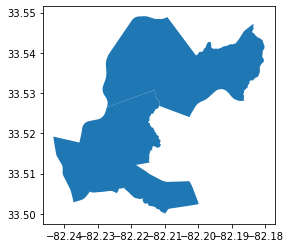

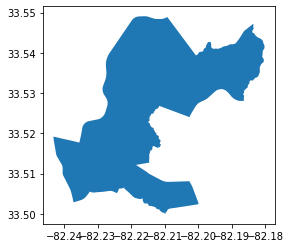

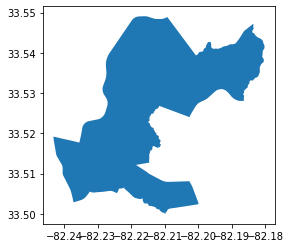

In [36]:
print(ga_election.shape)
print(precinct_shapes_ga.shape)

print(precinct_shapes_ga["unique_ID"].value_counts())
print(ga_election["unique_ID"].value_counts())

#Merge the Patriots Park precincts, as this seems to be what VEST did
precinct_shapes_ga[precinct_shapes_ga["unique_ID"]=="073PATRIOTS PARK"].plot()
vest_ga_18[vest_ga_18["PRECINCT_N"]=="PATRIOTS PARK"].plot()

prec2combine = precinct_shapes_ga[precinct_shapes_ga["unique_ID"]=="073PATRIOTS PARK"]
val = precinct_shapes_ga[precinct_shapes_ga["unique_ID"]=="073PATRIOTS PARK"].unary_union
precinct_shapes_ga.iat[790,12]="073PATRIOTS PARK-to-combine"
#precinct_shapes_ga.loc[precinct_shapes_ga["unique_ID"]=="073PATRIOTS PARK","geometry"] = gp.GeoDataFrame(geometry=[val]).geometry.values
precinct_shapes_ga.loc[precinct_shapes_ga["unique_ID"]=="073PATRIOTS PARK","geometry"] = val
precinct_shapes_ga = precinct_shapes_ga[precinct_shapes_ga["unique_ID"]!="073PATRIOTS PARK-to-combine"]
precinct_shapes_ga[precinct_shapes_ga["unique_ID"]=="073PATRIOTS PARK"].plot()

In [37]:
election_shapefile = pd.merge(ga_election,precinct_shapes_ga,on='unique_ID',how='outer',indicator="main_merge")
elections_only = election_shapefile[election_shapefile["main_merge"]=="left_only"]
shapefile_only = election_shapefile[election_shapefile["main_merge"]=="right_only"]
both_1 = election_shapefile[election_shapefile["main_merge"]=="both"]

print("There are " + str(elections_only['unique_ID'].count()) + " precincts that only appear in the election results")
print("There are " + str(shapefile_only['unique_ID'].count()) + " precincts that only appear in the shapefile")
print("There are " + str(both_1['unique_ID'].count()) + " precincts that were matched between the two files")

#elections_only_export = pd.Series(elections_only)
#elections_only.to_csv("./elections_only.csv")

#shapefile_only_export = pd.Series(shapefile_only)
#shapefile_only.to_csv("./shapefile_only.csv")

for i in elections_only["unique_ID"]:
    print(i)
for i in shapefile_only["unique_ID"]:
    print(i)


There are 0 precincts that only appear in the election results
There are 0 precincts that only appear in the shapefile
There are 2657 precincts that were matched between the two files


In [38]:
vest_ga_18["unique_ID"]=vest_ga_18["FIPS2"]+vest_ga_18["PRECINCT_N"]
vest_ga_18["unique_ID"] = np.where(vest_ga_18["unique_ID"].isna(), vest_ga_18["DISTRICT"], vest_ga_18["unique_ID"])

In [39]:
vest_ga_18.loc[vest_ga_18['CTYSOSID'] == "0513-15C","unique_ID"]= "0513-15 ELI WHITNEY COMPLEX"
vest_ga_18.loc[vest_ga_18['CTYSOSID'] == "0512-06C","unique_ID"]= "0512-06 ELI WHITNEY"
election_shapefile.loc[election_shapefile["unique_ID"] == "135PINKCNEYVILLE A","unique_ID"]="135PINCKNEYVILLE A"

In [40]:
#Merge Cloudland & Teloga precincts

#Deal with geometries
prec2combine = [vest_ga_18.loc[vest_ga_18["PRECINCT_N"]=="CLOUDLAND"],vest_ga_18.loc[vest_ga_18["PRECINCT_N"]=="TELOGA"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = vest_ga_18.crs)
vest_ga_18.loc[vest_ga_18["PRECINCT_N"]=="CLOUDLAND","geometry"]=new_fort.unary_union

vest_ga_18.loc[vest_ga_18["PRECINCT_N"]=="CLOUDLAND","unique_ID"] = "055CLOULDLAND-TELOGA"

#Update election results
results_columns = ['G18GOVRKEM', 'G18GOVDABR',
       'G18GOVLMET', 'G18LTGRDUN', 'G18LTGDAMI', 'G18SOSRRAF', 'G18SOSDBAR',
       'G18SOSLDUV', 'G18ATGRCAR', 'G18ATGDBAI', 'G18AGRRBLA', 'G18AGRDSWA',
       'G18INSRBEC', 'G18INSDLAW', 'G18INSLFOS', 'G18SPIRWOO', 'G18SPIDTHO',
       'G18LABRBUT', 'G18LABDKEA', 'G18PSCREAT', 'G18PSCDMIL', 'G18PSCLGRA',
       'G18PSCRPRI', 'G18PSCDRAN', 'G18PSCLTUR', 'R18SOSRRAF', 'R18SOSDBAR',
       'R18PSCREAT', 'R18PSCDMIL']

for i in results_columns:
        vest_ga_18.loc[vest_ga_18["unique_ID"] == "055CLOULDLAND-TELOGA",i]=int(vest_ga_18.loc[vest_ga_18["unique_ID"] == "055CLOULDLAND-TELOGA",i])+int(vest_ga_18.loc[vest_ga_18["unique_ID"] == "055TELOGA",i])
        

#Update dataframe
vest_ga_18 = vest_ga_18[vest_ga_18["PRECINCT_N"]!="TELOGA"]
vest_ga_18.reset_index(drop=True, inplace=True)

(2657, 53)
(2658, 39)
     DISTRICT CTYSOSID PRECINCT_I PRECINCT_N CTYNAME CTYNUMBER CTYNUMBER2  \
2651     None     None       None       None    None      None       None   

     FIPS2  G18GOVRKEM  G18GOVDABR  ...  G18PSCLGRA  G18PSCRPRI  G18PSCDRAN  \
2651  None           0           0  ...           0           0           0   

      G18PSCLTUR  R18SOSRRAF  R18SOSDBAR  R18PSCREAT  R18PSCDMIL  \
2651           0           0           0           0           0   

                                               geometry  unique_ID  
2651  POLYGON ((-84.64310 34.07798, -84.64331 34.077...       None  

[1 rows x 39 columns]
1.777737055187185e-18


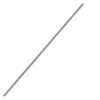

In [41]:
print(election_shapefile.shape)
print(vest_ga_18.shape)

print(vest_ga_18[vest_ga_18["unique_ID"].isna()])

print(vest_ga_18.iloc[2651]["geometry"].area)

display(vest_ga_18.iloc[2651]["geometry"])

In [42]:
final_shapefile = pd.merge(election_shapefile,vest_ga_18,on='unique_ID',how='outer',indicator="final_merge")
source_only = final_shapefile[final_shapefile["final_merge"]=="left_only"]
vest_only = final_shapefile[final_shapefile["final_merge"]=="right_only"]
both = final_shapefile[final_shapefile["final_merge"]=="both"]

print("There are " + str(source_only.shape[0]) + " precincts that only appear in the source")
print("There are " + str(vest_only.shape[0]) + " precincts that only appear in the vest")
print("There are " + str(both.shape[0]) + " precincts that were matched between the two files")

#elections_only_export = pd.Series(elections_only)
source_only.to_csv("./source_only.csv")

#shapefile_only_export = pd.Series(shapefile_only)
vest_only.to_csv("./vest_only.csv")

#shapefile_only_export = pd.Series(shapefile_only)
both.to_csv("./both.csv")

There are 0 precincts that only appear in the source
There are 1 precincts that only appear in the vest
There are 2657 precincts that were matched between the two files


In [43]:
#The same one from above
print(vest_only["unique_ID"])

2657    None
Name: unique_ID, dtype: object


## Validate Combined Merge

In [44]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff != 0):
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]['unique_ID'])
                if (diff>max_diff):
                    max_diff = diff
                    print("New max diff is: ", str(max_diff))
                    print(df.iloc[j]['unique_ID'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]['unique_ID'])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 5])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 5")
    print(diff_list)

In [45]:
column_List = ['G18GOVRKEM', 'G18GOVDABR','G18GOVLMET', 'G18LTGRDUN', 'G18LTGDAMI', 'G18SOSRRAF', 'G18SOSDBAR',
       'G18SOSLDUV', 'G18ATGRCAR', 'G18ATGDBAI', 'G18AGRRBLA', 'G18AGRDSWA',
       'G18INSRBEC', 'G18INSDLAW', 'G18INSLFOS', 'G18SPIRWOO', 'G18SPIDTHO',
       'G18LABRBUT', 'G18LABDKEA', 'G18PSCREAT', 'G18PSCDMIL', 'G18PSCLGRA',
       'G18PSCRPRI', 'G18PSCDRAN', 'G18PSCLTUR', 'R18SOSRRAF', 'R18SOSDBAR',
       'R18PSCREAT', 'R18PSCDMIL']
validater_row(both,column_List)

There are  2657  total rows
0  of these rows have election result differences
2657  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 5
[]


In [46]:
source_shapes = gp.GeoDataFrame(both, geometry='geometry_x')
vest_shapes = gp.GeoDataFrame(both, geometry='geometry_y')
vals = source_shapes.geom_almost_equals(vest_shapes,decimal=0)

In [47]:
print(vals.value_counts())

True     2482
False     175
dtype: int64


In [48]:
print(both[~vals]["unique_ID"].str[0:3].value_counts())
diff_precincts = gp.GeoDataFrame(both[~vals], geometry='geometry_x',crs=precinct_crs)
diff_total_area = diff_precincts.area

121    108
089     41
135     13
067      6
061      3
015      1
077      1
057      1
055      1
Name: unique_ID, dtype: int64


<ipython-input-48-43f791fbd6de>:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  diff_total_area = diff_precincts.area


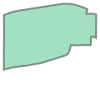

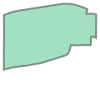

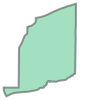

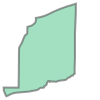

epsg:4019
epsg:4019


In [49]:
#Show a random difference
test = both[~vals].sample(axis=0,n=1).index[0]
display(both.iloc[test]["geometry_x"])
display(both.iloc[test]["geometry_y"])

test = both[~vals].sample(axis=0).index[0]
display(both.iloc[test]["geometry_x"])
display(both.iloc[test]["geometry_y"])

print(vest_ga_18.crs)
print(precinct_shapes_ga.crs)

<ipython-input-50-11bcd3d003d6>:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  diff_area = shp_difference.area


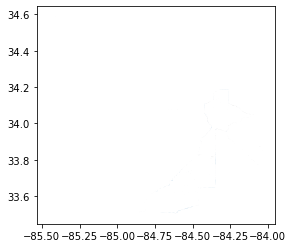

In [50]:
shp_difference = gp.overlay(source_shapes,vest_shapes,how='symmetric_difference')
shp_difference.plot()
diff_area = shp_difference.area

In [51]:
print("Difference area as a percent of the state of GA area:")
print(100*(sum(diff_area)/sum(vest_ga_18.area)))
print("")
print("Difference area as a percent of the precincts where there are differences area:")
print(100*(sum(diff_area))/sum((diff_total_area)))

<ipython-input-51-57e5ae2cdfa1>:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(100*(sum(diff_area)/sum(vest_ga_18.area)))


Difference area as a percent of the state of GA area:
0.0011786091539664157

Difference area as a percent of the precincts where there are differences area:
0.11955377111512092
